http://everettsprojects.com/2018/01/17/mnist-visualization.html

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import keras
from keras.models import load_model
from keras import backend as K
from tqdm import tqdm

import os
from os.path import join

# Set the learning phase to false, the model is pre-trained.
K.set_learning_phase(False)
model = load_model('models/mnist_conv_deep_01.h5')

Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [3]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [4]:
# A placeholder for the input images
input_img = model.input

# Dimensions of the images
img_width = 28
img_height = 28

# A constant size step function for gradient ascent
def constant_step(total_steps, step, step_size = 1):
    return step_size

# Define an initial divisor and decay rate for a varied step function
# This function works better than constant step for the output layer
init_step_divisor = 100
decay = 10

def vary_step(total_steps, step):
    return (1.0 / (init_step_divisor + decay * step))

In [5]:
# Function from the Keras blog that normalizes and scales
# a filter before it is rendered as an image
def normalize_image(x):
    # Normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # Clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # Convert to grayscale image array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
# Create a numpy array that represents the image of a filter
# in the passed layer output and loss functions. Based on the
# core parts of Francois Chollet's blog post.
def visualize_filter(layer_output, loss, steps = 256, step_fn = constant_step, input_initialization = 'random'):
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 1)

    # Initialize the input image. Random works well for the conv layers,
    # zeros works better for the output layer.
    input_img_data = np.random.random(input_shape) * 255.
    if input_initialization == "zeros":
        input_img_data = np.zeros(input_shape)
    input_img_data = np.array(input_img_data).reshape(1, 28, 28, 1)

    # Run gradient ascent for the specified number of steps
    for i in range(steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step_fn(steps, i)

    final_img = input_img_data[0]

    return final_img

In [7]:
# Define a function that stitches the 28 * 28 numpy arrays
# together into a collage of filters for each layer.
def stitch_filters(layer_filters, y_img_count, x_img_count):
    margin = 2
    width = y_img_count * img_width + (y_img_count - 1) * margin
    height = x_img_count * img_height + (x_img_count - 1) * margin
    stitched_filters = np.zeros((width, height))

    # Fill the picture with our saved filters
    for i in range(y_img_count):
        for j in range(x_img_count):
            img = layer_filters[i * x_img_count + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height] = img

    return stitched_filters

In [8]:
def visualize_filters(layer_name, layer_image):
    fig = plt.figure(figsize=(10.0,10.0))
    plt.imshow(layer_image, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(layer_name)
    plt.savefig(join('./figs', layer_name) )
    plt.show()
    
def construct_filters_image(layer_name, nfilters, nx, ny):
    layer_filters = []
    # For each filter in this layer
    for i in range(nfilters):
        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, i])
        img = visualize_filter(layer_output, loss)
        layer_filters.append(img.reshape(28,28))
    layer_filters = [normalize_image(image) for image in layer_filters]      
    layer_image = stitch_filters(layer_filters, nx, ny)
    return layer_image

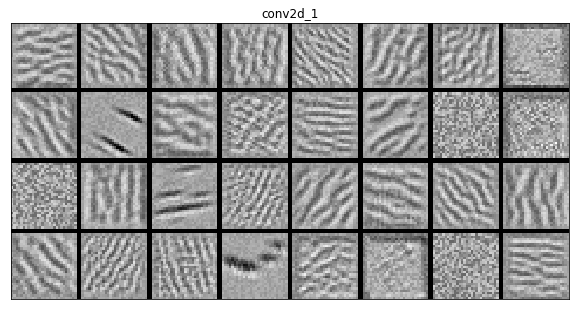

In [9]:
# First convolutional layer
layer_name = 'conv2d_1'
visualize_filters(layer_name, construct_filters_image(layer_name,32,4,8))

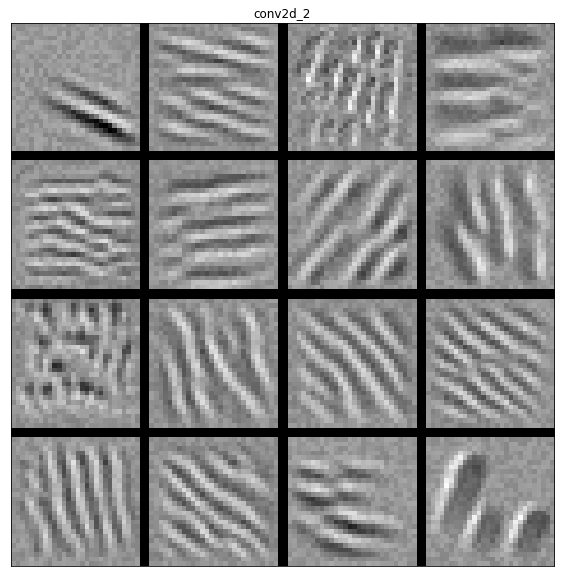

In [10]:
# The second convolutional layer
layer_name = 'conv2d_2'
visualize_filters(layer_name, construct_filters_image(layer_name,16,4,4))

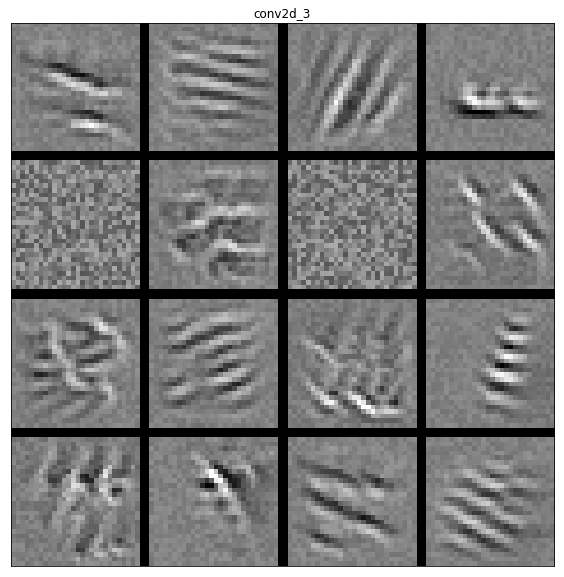

In [11]:
# The third convolutional layer
layer_name = 'conv2d_3'
visualize_filters(layer_name, construct_filters_image(layer_name,16,4,4))

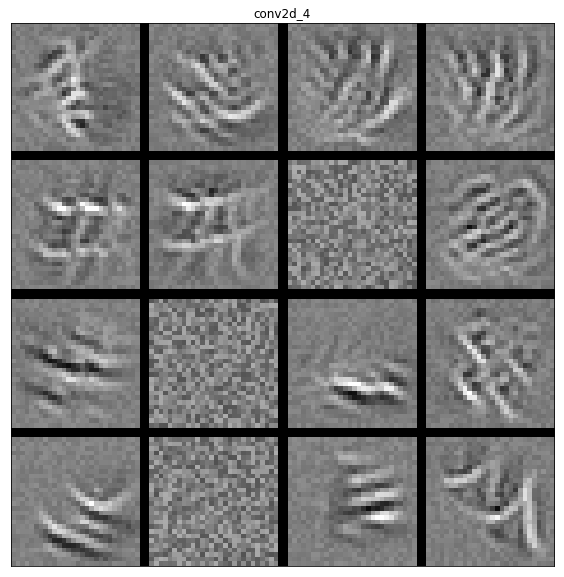

In [12]:
# The fourth layer
layer_name = 'conv2d_4'
visualize_filters(layer_name, construct_filters_image(layer_name,16,4,4))

In [15]:
# The final output layer of the model
output_filters = []
nsteps = 2048

for i in tqdm(range(10)):
    output = model.output
    loss = K.mean(output[:, i])
    img = visualize_filter(output, loss,
                          steps = nsteps,
                          step_fn = vary_step,
                          input_initialization = 'zeros')
    output_filters.append(img.reshape(28,28))
output_image_raw = stitch_filters(output_filters, 2, 5)

100%|██████████| 10/10 [01:37<00:00,  9.46s/it]


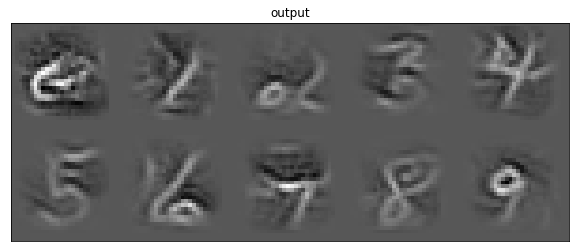

In [19]:
visualize_filters('output', output_image_raw)

In [20]:
# The above output filters are very grey, which isn't the way the
# original MNIST digits are represented.
def deaverage_digit(digit):
    deaveraged_digit = np.clip(digit - digit.mean(), 0, 255)
    deaveraged_digit *= (255.0/deaveraged_digit.max())
    return deaveraged_digit

deaveraged_outputs = [deaverage_digit(x) for x in output_filters]
output_image_deaveraged = stitch_filters(deaveraged_outputs, 2, 5)

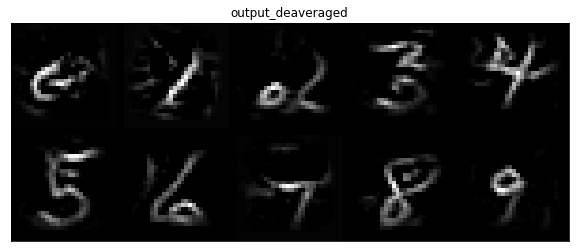

In [21]:
visualize_filters('output_deaveraged', output_image_deaveraged)